# Monomial gamma HMC

In [1]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import pints.plot

from pints.functionaltests.monomial_gamma_hamiltonian import (
    test_monomial_gamma_hamiltonian_on_banana,
    test_monomial_gamma_hamiltonian_on_two_dim_gaussian,
    test_monomial_gamma_hamiltonian_on_high_dim_gaussian,
    test_monomial_gamma_hamiltonian_on_correlated_gaussian,
    test_monomial_gamma_hamiltonian_on_annulus,
    test_monomial_gamma_hamiltonian_on_multimodal_gaussian,
    test_monomial_gamma_hamiltonian_on_cone)
os.chdir("method-merge-tests/")

In [2]:
def run_replicates(iterations, n_replicates, test):
    df = pd.DataFrame(columns=['iterations', 'replicate', 'kld', 'ess'],
                      index=np.arange(len(iterations) * n_replicates))
    k = 0
    for it in iterations:
        for rep in range(n_replicates):
            result = test(it)
            df.iloc[k] = {'iterations': it, 'replicate': rep,
                          'kld': result['kld'], 'ess': result['mean-ess']}
            k += 1
    df['iterations'] = pd.to_numeric(df['iterations'])
    df['kld'] = pd.to_numeric(df['kld'])
    df['ess'] = pd.to_numeric(df['ess'])
    return df

def ecdf_norm_plotter(draws, normal_sd, xrange=np.linspace(-5, 5, 100)):
    from scipy.stats import norm
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf_fun = ECDF(draws)
    ecdf = [ecdf_fun(y) for y in xrange]
    cdf = [norm.cdf(y, 0, normal_sd) for y in xrange]
    
    x1 = np.linspace(0, 1, 100)
    y = [y for y in x1]
    plt.scatter(ecdf, cdf)
    plt.plot(x1, y, 'k-')
    plt.xlabel('Estimated cdf')
    plt.ylabel('True cdf')
    plt.show()

def run_replicates_distance(iterations, n_replicates, test):
    df = pd.DataFrame(columns=['iterations', 'replicate', 'distance', 'ess'],
                      index=np.arange(len(iterations) * n_replicates))
    k = 0
    for it in iterations:
        for rep in range(n_replicates):
            result = test(it)
            df.iloc[k] = {'iterations': it, 'replicate': rep,
                          'distance': result['distance'], 'ess': result['mean-ess']}
            k += 1
    df['iterations'] = pd.to_numeric(df['iterations'])
    df['distance'] = pd.to_numeric(df['distance'])
    df['ess'] = pd.to_numeric(df['ess'])
    return df

# Two dimensional Gaussian

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


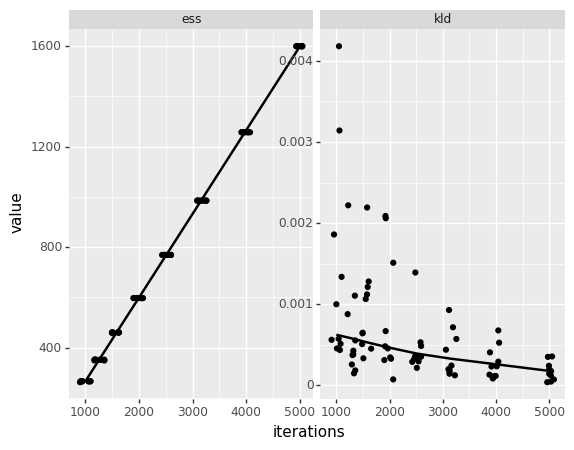

<ggplot: (343949025)>

In [3]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates(10**np.linspace(low, high, 8), 10,
                      test_monomial_gamma_hamiltonian_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_2d_gaussian.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.


/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:06.4
1     84     0.333     0.333     0.333     0.333      0:06.4
2     164    0.5       0.5       0.5       0.5        0:06.5
3     244    0.6       0.6       0.6       0.6        0:06.5
20    1604   0.909     0.909     0.818     0.909      0:06.7
40    3204   0.952381  0.952381  0.857     0.952381   0:07.0
60    4804   0.968     0.968     0.903     0.968      0:07.2
80    6404   0.976     0.976     0.927     0.976      0:07.5
100   8004   0.98      0.98      0.941     0.98       0:07.8
120   9604   0.984     0.984     0.951     0.984      0:08.1
140   11204  0.986     0.986     0.958     0.986      0:08.4
160   12804  0.988     0.988     0.962963  0.988      0:08.6
180   14404  0.989011  0.989011  0.967033  0.989011   0:08.9
200   16004  0.990099  0.990099  0.970297  0.990099   0:09.2
220   17604  0.990991  0.990991  0.972973  0.990991   0:09.5
240   19204  0.992     0

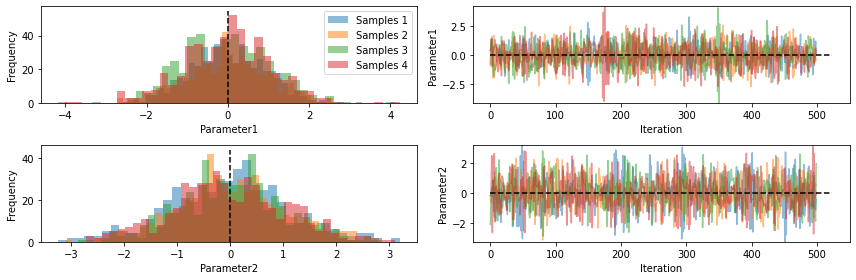

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.01   1.03    -2.00   -0.71  -0.00  0.70   1.92     1.00    666.67  33.26
param 2  -0.01   1.04    -2.15   -0.70  -0.03  0.66   2.08     1.00    666.67  33.26


In [4]:
n_chains = 4
n_iterations = 1000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(True)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

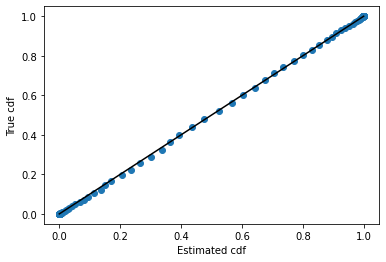

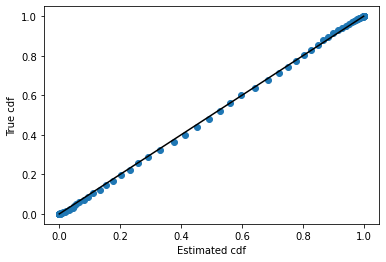

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


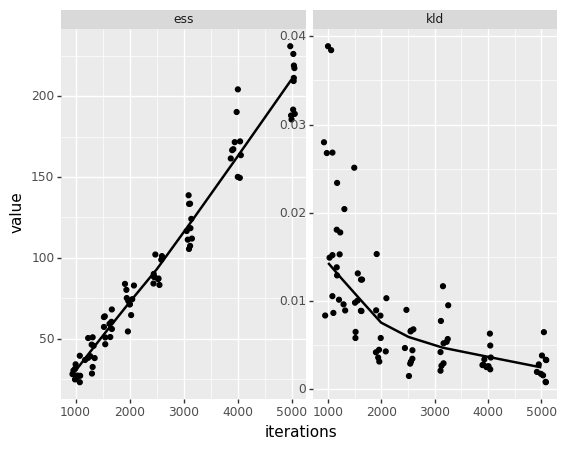

<ggplot: (343918013)>

In [6]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates(10**np.linspace(low, high, 8), 10,
                      test_monomial_gamma_hamiltonian_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_correlated_gaussian.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


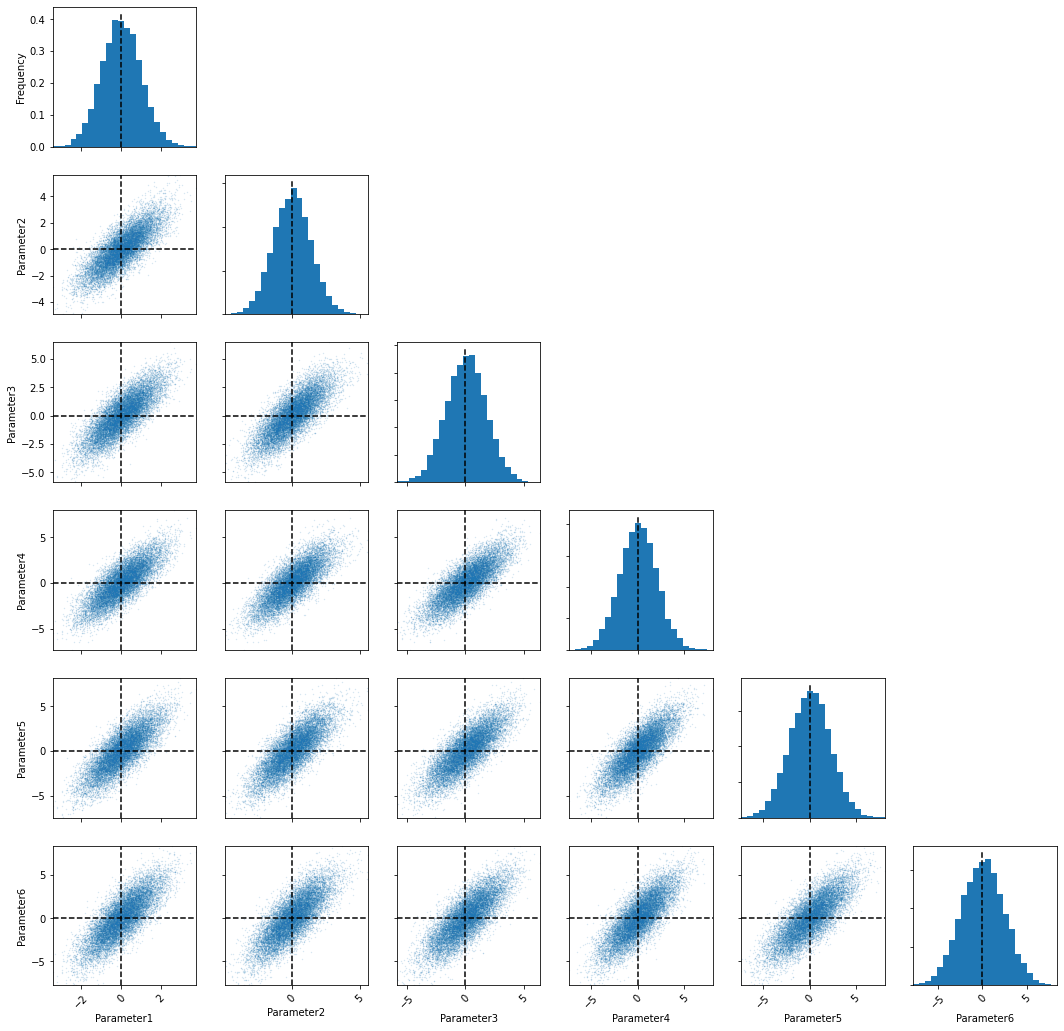

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.03    0.98    -1.89   -0.64  0.02   0.69   1.97     1.00    678.02  7.95
param 2  0.04    1.41    -2.69   -0.93  0.04   0.98   2.82     1.00    674.70  7.91
param 3  0.06    1.70    -3.24   -1.09  0.06   1.20   3.40     1.00    630.63  7.40
param 4  0.07    1.97    -3.82   -1.26  0.09   1.40   3.95     1.00    626.22  7.35
param 5  0.06    2.19    -4.29   -1.44  0.09   1.54   4.33     1.00    614.20  7.21
param 6  0.09    2.41    -4.62   -1.55  0.12   1.72   4.77     1.00    617.48  7.24


In [7]:
n_chains = 4
n_iterations = 4000
n_warmup = 500

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

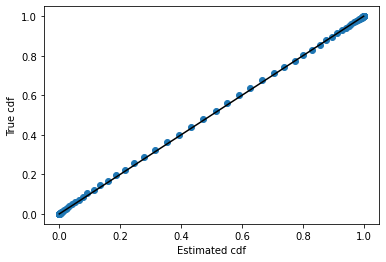

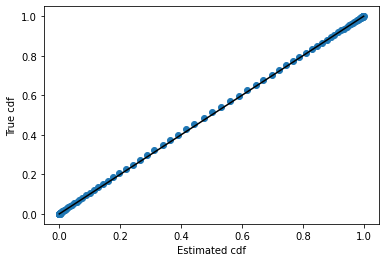

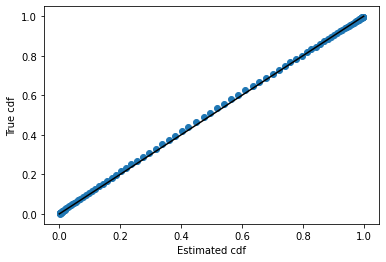

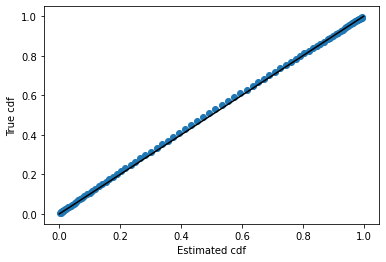

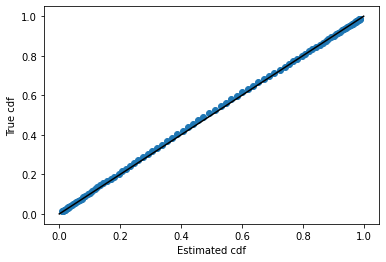

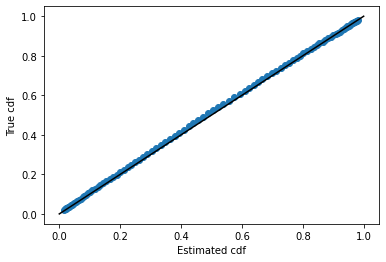

[None, None, None, None, None, None]

In [8]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


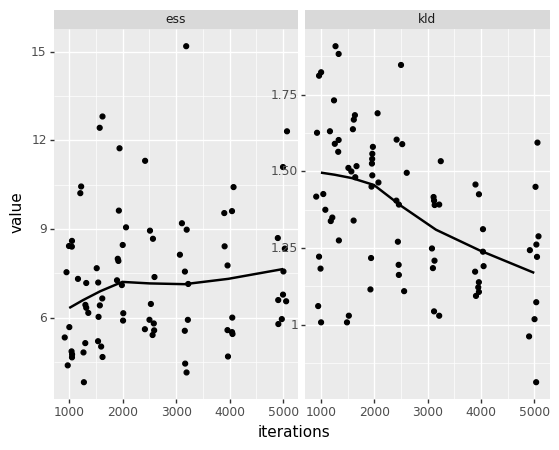

<ggplot: (350064185)>

In [9]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_monomial_gamma_hamiltonian_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_banana.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem with a low ESS. But the KLD is moving in the right direction.

Example run of results.

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


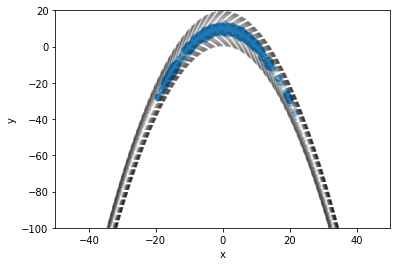

In [10]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


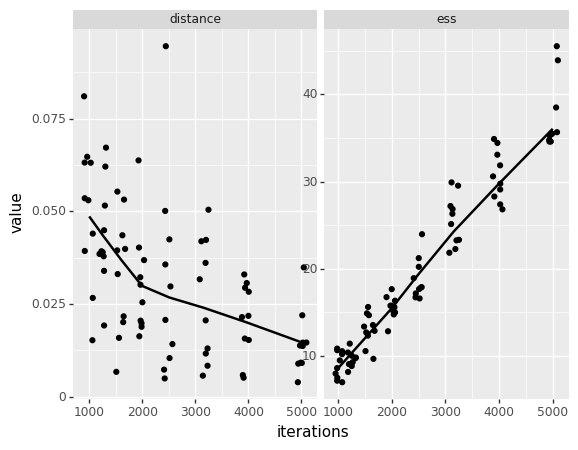

<ggplot: (346615793)>

In [11]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates_distance(10**np.linspace(low, high, 8), 10,
                              test_monomial_gamma_hamiltonian_on_annulus)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_annulus.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


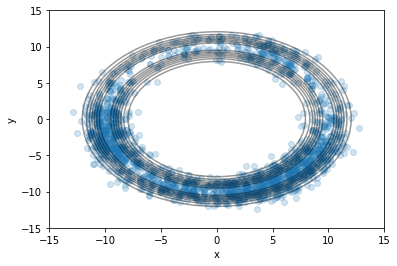

In [12]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodal Gaussian

/Volumes/Samsung1.5TB/Github/pints/pints/toy/_multimodal_gaussian.py:167: RuntimeWarning: Degrees of freedom <= 0 for slice
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


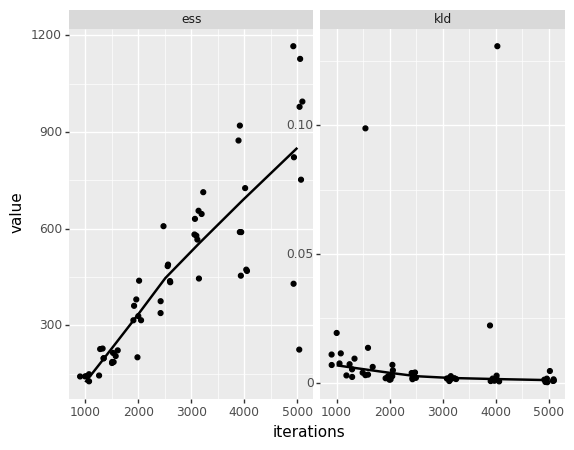

<ggplot: (346645781)>

In [13]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates(10**np.linspace(low, high, 8), 10,
                      test_monomial_gamma_hamiltonian_on_multimodal_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_multimodal_gaussian.csv")

# remove high values of kld to see general trend
test1 = test.query('kld < 1')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])
(ggplot(df1,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

With the few outliers removed, the KLD appears to be moving in the correct direction as iterations increase.

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


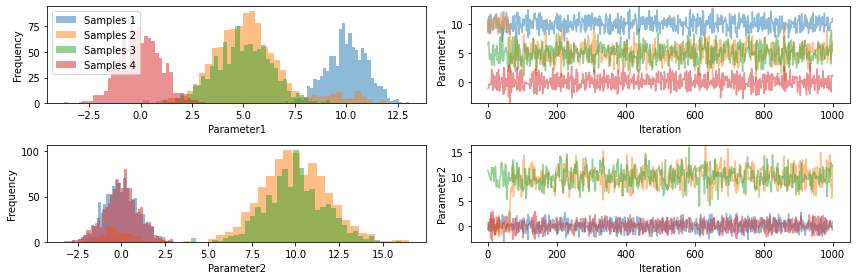

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.08    3.79    -1.25   1.95   5.06   8.52   11.27    3.03    876.63  17.40
param 2  4.83    5.19    -1.60   -0.05  1.81   9.91   12.86    3.00    838.90  16.65


In [18]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Clearly this multimodal distribution requires many draws to reach convergence.

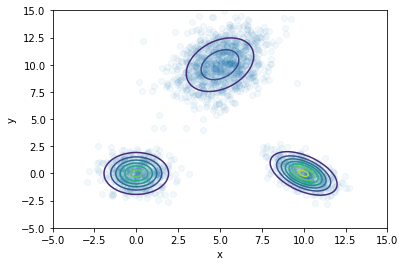

In [19]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


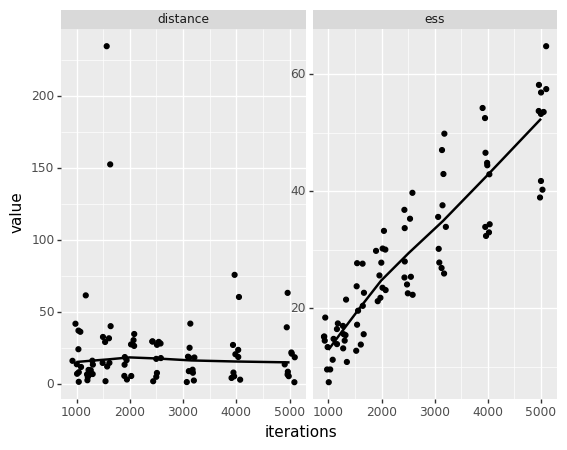

<ggplot: (346226329)>

In [16]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates_distance(10**np.linspace(low, high, 8), 10,
                               test_monomial_gamma_hamiltonian_on_cone)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_cone.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Again, the cone problem, with its long tails, is really hard.

Now showing an example run.

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.


/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:06.3
1     84     0.333     0.333     0.333     0.333      0:06.3
2     164    0.5       0.5       0.5       0.25       0:06.3
3     244    0.4       0.6       0.6       0.4        0:06.3
20    1604   0.818     0.818     0.909     0.818      0:06.5
40    3204   0.905     0.857     0.952381  0.857      0:06.7
60    4804   0.935     0.887     0.968     0.887      0:07.0
80    6404   0.951     0.89      0.976     0.915      0:07.2
100   8004   0.961     0.912     0.98      0.931      0:07.5
120   9604   0.967     0.918     0.984     0.942623   0:07.7
140   11204  0.965     0.93      0.986     0.951      0:07.9
160   12804  0.969     0.938     0.981     0.957      0:08.1
180   14404  0.967033  0.94      0.984     0.962      0:08.4
200   16004  0.965     0.946     0.975     0.965      0:08.6
220   17604  0.968     0.95      0.977     0.963964   0:08.8
240   19204  0.967     0

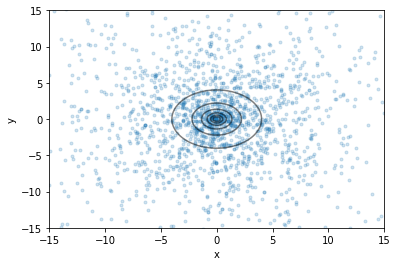

True normed mean = 8.638816024714002
Sample normed mean = 9.156732700158106
True normed var = 65.40423915068341
Sample normed var = 63.01658204140811


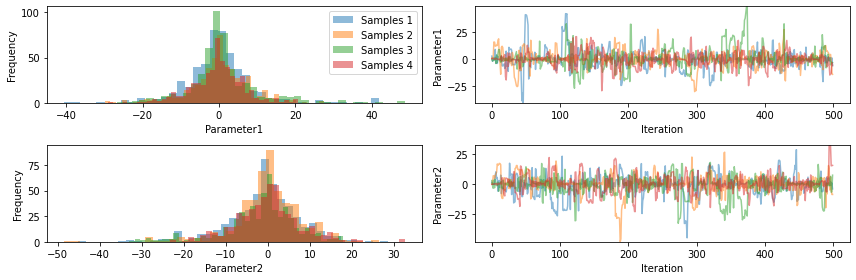

In [17]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.MonomialGammaHamiltonianMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(1000)

# Disable logging
mcmc.set_log_to_screen(True)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(5)
    sampler.set_a(0.5)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

/Volumes/Samsung1.5TB/Github/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:268: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


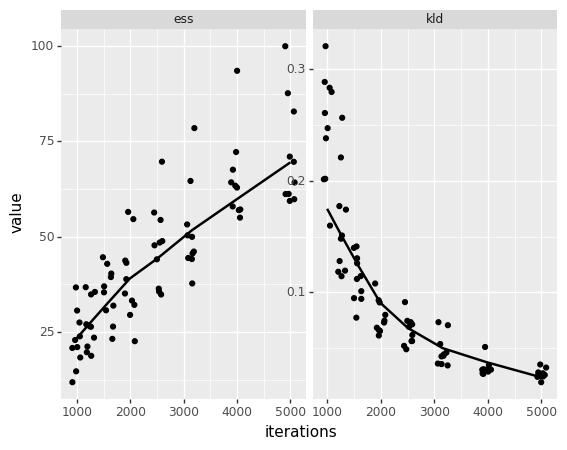

<ggplot: (351165989)>

In [20]:
low = np.log10(1000)
high = np.log10(5000)
test = run_replicates(10**np.linspace(low, high, 8), 10,
                      test_monomial_gamma_hamiltonian_on_high_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
df.to_csv("experimental_data/monomial_gamma_hamiltonian_high_dim_gaussian.csv")
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))